# 1.0 Notebook Setup

Note: need to mount your Google Drive to use the adult dataset. 

In [1]:
# Optional - used by our team to record outputs
!pip install wandb

# Used for fairness evaluation metrics 
!pip install fairlearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Other imports 

import pandas as pd
import plotly
import plotly.express as px
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import linear_model, metrics, preprocessing
from datetime import datetime, timedelta

import wandb
import random

from fairlearn.postprocessing import ThresholdOptimizer, plot_threshold_optimizer
from fairlearn.metrics import demographic_parity_ratio, equalized_odds_ratio, demographic_parity_difference, equalized_odds_difference
from fairlearn.reductions import DemographicParity


from google.colab import drive

from sklearn.model_selection import KFold, cross_val_score


drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2.0 Supporting Functions and Classes

## 2.1 Defining Regularizers 

In [3]:
import torch
from torch import nn
from torch.nn import functional as F


class ConstraintLoss(nn.Module):
    def __init__(self, n_class=2, alpha=1, p_norm=2):
        super(ConstraintLoss, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.alpha = alpha
        self.p_norm = p_norm
        self.n_class = n_class
        self.n_constraints = 2
        self.dim_condition = self.n_class + 1
        self.M = torch.zeros((self.n_constraints, self.dim_condition))

    #NOTE!!! --> We never call the parent mu_f in super so it was removed

    def forward(self, X, out, sensitive, y=None):
        # Reshapes sensitive attribute tensor to the same shape as the output 
        sensitive = sensitive.view(out.shape)
        # Reshapes y (label) tensor to the same shape as the output 
        if isinstance(y, torch.Tensor):
            y = y.view(out.shape)

        #Take the sigmoid of 'out' which is the output of our model (aka the weights). 
        #out = torch.sigmoid(out)

        # Get the mu_f value given these tensors by calling the subclass mu_f
        #mu_f is the expected value of a sensitive feature in DP
        # print("super forward -> sub-class mu_f called")
        mu = self.mu_f(X=X, out=out, sensitive=sensitive, y=y)
        
        # Gap constraint refers to the difference beteween the two sensitive classes as calculated by taking the .mv (dot product)
        # Apply relu to matrix vector product of M and mu which 
        # Using cuda if applicable (self.device references)
        gap_constraint = F.relu(
            torch.mv(self.M.to(self.device), mu.to(self.device))
        )
        # print("super forwad -> M*mu gap constraints")

        # Using the L2 Norm of the gap constraint as regularizer with alpha parameter. 
        if self.p_norm == 2:
            cons = self.alpha * torch.dot(gap_constraint, gap_constraint)
        else:
            cons = self.alpha * torch.dot(gap_constraint.detach(), gap_constraint)
        return cons


class DemographicParityLoss(ConstraintLoss):
    def __init__(self, sensitive_classes=[0, 1], alpha=1, p_norm=2):
        """loss of demograpfhic parity

        Args:
            sensitive_classes (list, optional): list of unique values of sensitive attribute. Defaults to [0, 1].
            alpha (int, optional): [description]. Defaults to 1.
            p_norm (int, optional): [description]. Defaults to 2.
        """
        self.sensitive_classes = sensitive_classes
        self.n_class = len(sensitive_classes)
        super(DemographicParityLoss, self).__init__(
            n_class=self.n_class, alpha=alpha, p_norm=p_norm
        )
        self.n_constraints = self.n_class
        self.dim_condition = self.n_class
        self.M = torch.zeros((self.n_constraints, self.dim_condition))
        for i in range(self.n_constraints):
            j = i % 2
            if j == 0:
                self.M[i, j] = 1.0
                self.M[i, 1] = -1.0
            else:
                self.M[i, j - 1] = -1.0
                self.M[i, 1] = 1.0
        # print("DP_init -> M defined")

    def mu_f(self, X, out, sensitive, y=None):
        # print("sub-class mu_f -> return exp vals")
        expected_values_list = []
        for v in self.sensitive_classes:
            # Get the index for each of the senstive classes 
            idx_true = sensitive == v  # torch.bool
            # Get the average prediction for that sensitive class
            expected_values_list.append(out[idx_true].mean())

        #expected_values_list will have two values, one for each sensitive class representing it's average prediction
        #if you look at forward you'll see we take the dot product of these two values with M
        return torch.stack(expected_values_list)

    def forward(self, X, out, sensitive, y=None):
        #Calls parent class forward function
        # print("sub-class forward -> call super forward")
        return super(DemographicParityLoss, self).forward(X, out, sensitive)


class EqualizedOddsLoss(ConstraintLoss):
    def __init__(self, sensitive_classes=[0, 1], alpha=1, p_norm=2):
        """loss of demograpfhic parity
        Args:
            sensitive_classes (list, optional): list of unique values of sensitive attribute. Defaults to [0, 1].
            alpha (int, optional): [description]. Defaults to 1.
            p_norm (int, optional): [description]. Defaults to 2.

            equalized odds: pr(y_hat | A=a, Y=y) = pr(y_hat | Y=y) for all a in A, y in Y.
            pr(y_hat =1 | A=a1, Y=y) = pr(y_hat =1 | A=a2, Y=y) for all y
        """
        self.sensitive_classes = sensitive_classes
        self.y_classes = [0, 1] # binary classification
        self.n_class = len(sensitive_classes)
        self.n_y_class = len(self.y_classes)
        super(EqualizedOddsLoss, self).__init__(n_class=self.n_class, alpha=alpha, p_norm=p_norm)
        # K:  number of constraint : (|A| x |Y| x {+, -})
        self.n_constraints = self.n_class * self.n_y_class
        # J : dim of conditions  : ((|A|+1) x |Y|)
        self.dim_condition = self.n_class* self.n_y_class
        self.M = torch.zeros((self.n_constraints, self.dim_condition))
        # print(self.M)
        #hard coded M matrix
        for i in range(self.n_constraints):
              if i==0:
                self.M[i, i] = 1.0
                self.M[i, i+2] = -1.0
              elif i == 1:
                self.M[i, i-1] = -1.0
                self.M[i, i+1] = 1.0
              elif i==2:
                self.M[i, i-1] = -1.0
                self.M[i, i+1] = 1.0
              elif i==3:
                self.M[i, i-2] = 1.0
                self.M[i, i] = -1.0
        #print(self.M)
                
    def mu_f(self, X, out, sensitive, y):
        expected_values_list = []
        # print(self.sensitive_classes)
        # print(self.y_classes)
        for u in self.sensitive_classes:
            for v in self.y_classes:
                # print("HERE")
                idx_true = (y == v) * (sensitive == u)  # torch.bool
                expected_values_list.append(out[idx_true].mean())
        # print(expected_values_list)
        # print("Loop")
        return torch.stack(expected_values_list)

    def forward(self, X, out, sensitive, y):
        return super(EqualizedOddsLoss, self).forward(X, out, sensitive, y=y)

## 2.2 Defining Models

In [4]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        print ("HELLO")
        nn.init.xavier_uniform_(m.weight.data)
        # nn.init.xavier_uniform_(m.bias.data)
    
# https://towardsdatascience.com/logistic-regression-with-pytorch-3c8bbea594be
class LogisticRegression(torch.nn.Module):
     def __init__(self, input_dim, output_dim):
         super(LogisticRegression, self).__init__()
         self.linear = torch.nn.Linear(input_dim, output_dim)
     def forward(self, x):
         (self.linear) 

         outputs = torch.sigmoid(self.linear(x))
         return outputs


# https://medium.com/analytics-vidhya/pytorch-for-deep-learning-binary-classification-logistic-regression-382abd97fb43
class Net(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32,16)
        self.fc3 = nn.Linear(16, output_dim)
    def forward(self,x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

## 2.3 Data Loaders

### 2.3.1 COMPAS

In [5]:
def load_compas(sensitive_name = 'race'): 
  # Load Data 
  compas_link ='https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv'
  compas_data = pd.read_csv(compas_link, on_bad_lines='skip')

  # Trim Undesired Columns 
  compas_data = compas_data[['age' , 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count','sex','c_charge_degree','race','two_year_recid']]
  compas_to_oh = ['sex','c_charge_degree']

  # Fix Race 
  compas_data.loc[compas_data.race != 'Caucasian', 'race'] = 1
  compas_data.loc[compas_data.race == 'Caucasian', 'race'] = 0
  compas_data.race = compas_data.race.astype(int)

  # Get Sensitive 
  sensitive = compas_data[[sensitive_name]]

  # One-hot-encode sex & c_charge_degree
  compas_data = pd.get_dummies(compas_data, columns = compas_to_oh)

  # Returns x, y, sensitive (with sensitive still included in x )
  return compas_data, sensitive



### 2.3.2 Adult

In [6]:
def load_adult(sensitive_name = 'sex_binary'): 

  # Load Data 
  adult_data = pd.read_csv("/content/drive/MyDrive/Project/Data/adult.csv")

  # Create binary for race 
  adult_data.loc[adult_data.race != ' White', 'race_binary'] = 1
  adult_data.loc[adult_data.race == ' White', 'race_binary'] = 0
  adult_data.race = adult_data.race_binary.astype(int)

  # Create binary for sex 
  adult_data.loc[adult_data.sex != ' Male', 'sex_binary'] = 1
  adult_data.loc[adult_data.sex == ' Male', 'sex_binary'] = 0
  adult_data.sex = adult_data.sex_binary.astype(int)

  # Create binary for income 
  adult_data.loc[adult_data.income != ' >50K', 'income'] = 0
  adult_data.loc[adult_data.income == ' >50K', 'income'] = 1
  adult_data.income = adult_data.income.astype(int)

  adult_data = adult_data[['marital-status','occupation','race_binary','sex_binary','education_num', 'capital_gain', 'capital_loss', 'hours_per_week','income']]

  # One hot encode 
  adult_to_oh = ['marital-status', 'occupation']
  adult_data = pd.get_dummies(adult_data,columns=adult_to_oh)
  
  sensitive = adult_data[sensitive_name]
  
  return adult_data, sensitive

def get_balanced_adult():
  # Load Data 
  df = pd.read_csv("/content/drive/MyDrive/Project/Data/adult.csv")
  df_pos = df.loc[df.income==' >50K']
  df_neg = df.loc[df.income==' <=50K']
  df_neg_sample = df_neg.sample(len(df_pos),random_state=15)
  df_new = pd.concat([df_pos,df_neg_sample],axis=0)
  return df_new

def load_adult_balanced(target_name = 'income', sensitive_name = 'sex_binary'):

  # Load Data 
  adult_data = get_balanced_adult()

  # Create binary for race 
  adult_data.loc[adult_data.race != ' White', 'race_binary'] = 1
  adult_data.loc[adult_data.race == ' White', 'race_binary'] = 0
  adult_data.race = adult_data.race_binary.astype(int)

  # Create binary for sex 
  adult_data.loc[adult_data.sex != ' Male', 'sex_binary'] = 1
  adult_data.loc[adult_data.sex == ' Male', 'sex_binary'] = 0
  adult_data.sex = adult_data.sex_binary.astype(int)

  # Create binary for income 
  adult_data.loc[adult_data.income != ' >50K', 'income'] = 0
  adult_data.loc[adult_data.income == ' >50K', 'income'] = 1
  adult_data.income = adult_data.income.astype(int)

  adult_data = adult_data[['marital-status','occupation','race_binary','sex_binary','education_num', 'capital_gain', 'capital_loss', 'hours_per_week','income']]

  # One hot encode 
  adult_to_oh = ['marital-status', 'occupation']
  adult_data = pd.get_dummies(adult_data,columns=adult_to_oh)
  
  sensitive = adult_data[sensitive_name]
  
  return adult_data, sensitive


## 2.4 Data Helpers

In [7]:
def label_encode(df):

  for i in df.columns:
    tmp = df[i].iloc[0]
    
    if type(tmp) != int or type(tmp) != float:
      le = preprocessing.LabelEncoder()
      df[i] = le.fit_transform(df[i].values)

  return df

def one_hot(df):
  
  for i in df.columns:
    tmp = df[i].iloc[0]

    if i == 'Loan_Status':
      pass
    elif type(tmp) == str:
      df = pd.get_dummies(df, columns = [i])
      # ohe = preprocessing.OneHotEncoder()
      # df[i] =  ohe.fit_transform(df[i].values.reshape(-1, 1)) # double check the shape

  return df


def get_dataset(name, target = None, sensitive = None):
  if name == 'compas':
    print ("*")
    df, sensitive_name = load_compas()
  
  if name == 'adult':
    df, sensitive_name = load_adult()
  
  if name == 'adult_balanced':
    df, sensitive_name = load_adult_balanced()

  # else: 
  #   df = pd.read_csv("/content/drive/MyDrive/Project/Data/adult.csv")
  #   df = label_encode(df)

  return df, sensitive_name

def split(x, y, sensitive_features,  train_ratio, test_ratio):
  validation_ratio = 100 - train_ratio - test_ratio

  if validation_ratio < 0:
    print ("Incorrect Ratios")
    return -1

  # train is now 75% of the entire data set
  x_train, x_test, y_train, y_test, a_train, a_test = train_test_split(x, y, sensitive_features, test_size=1 - train_ratio, random_state=32)

  # test is now 10% of the initial data set
  # validation is now 15% of the initial data set
  x_val, x_test, y_val, y_test, a_val, a_test = train_test_split(x_test, y_test, a_test, test_size=test_ratio, random_state=32) 

  return  x_train, x_test, x_val, y_train, y_test, y_val, a_train, a_test, a_val


## 2.5 Evaluation Functions

In [24]:
def mae(prediction, true):
  return metrics.mean_absolute_error(true, prediction)

def accuracy(prediction, true):
  true = true.detach().numpy()
  prediction = prediction.detach().numpy()
  prediction = np.where( prediction <= 0.5, 0, 1)

  return (metrics.accuracy_score(true, prediction))

def precision(prediction, true):
  true = true.detach().numpy()
  prediction = prediction.detach().numpy()
  prediction = np.where( prediction <= 0.5, 0, 1)
  return (metrics.precision_score(true, prediction))

def recall(prediction, true):
  true = true.detach().numpy()
  prediction = prediction.detach().numpy()
  prediction = np.where( prediction <= 0.5, 0, 1)
  return (metrics.recall_score(true, prediction))

def tpr(prediction, true):
  return np.logical_and(prediction == 1, true== 1).sum()/prediction.shape[0]

def fpr(prediction, true):
  return np.logical_and(prediction == 1, true== 0).sum()/prediction.shape[0]

def tnr(prediction, true):
  return np.logical_and(prediction == 0, true== 0).sum()/prediction.shape[0]

def fnr(prediction, true):
  return np.logical_and(prediction == 0, true== 1).sum()/prediction.shape[0]

# demographic_parity_ratio
def dpr(prediction, true, sensitive_features):
  true = true.detach().numpy()
  sensitive_features = sensitive_features.detach().numpy()
  prediction = prediction.detach().numpy()
  prediction = np.where( prediction <= 0.5, 0, 1)
  return demographic_parity_ratio(true,prediction, sensitive_features=sensitive_features)

# demographic_parity_difference
def dpd(prediction, true, sensitive_features):
  true = true.detach().numpy()
  sensitive_features = sensitive_features.detach().numpy()
  prediction = prediction.detach().numpy()
  prediction = np.where( prediction <= 0.5, 0, 1)
  return demographic_parity_difference(true,prediction, sensitive_features=sensitive_features)

# equalized_odds_ratio
def eor(prediction, true, sensitive_features):
  true = true.detach().numpy()
  sensitive_features = sensitive_features.detach().numpy()
  prediction = prediction.detach().numpy()
  prediction = np.where( prediction <= 0.5, 0, 1)
  return equalized_odds_ratio(true, prediction, sensitive_features=sensitive_features)

# equalized_odds_difference
def eod(prediction, true, sensitive_features):
  true = true.detach().numpy()
  sensitive_features = sensitive_features.detach().numpy()
  prediction = prediction.detach().numpy()
  prediction = np.where( prediction <= 0.5, 0, 1)
  return equalized_odds_difference(true,prediction, sensitive_features=sensitive_features)
  

## 2.6 Train and Test Functions

In [25]:
def test(model, x_test, y_test, a_test):
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)
  outputs = model(x_test.float()) 
  loss = criterion(outputs, y_test.float())

  # log model results
  wandb.log({"test_loss": loss.item(), 
          "test_accuracy": accuracy(outputs, y_test), 
          "test_precision": precision(outputs, y_test), 
          "test_recall": recall(outputs, y_test),
          "test_dpr": dpr(outputs, y_test.float(),a_test ),
          "test_dpd": dpd(outputs, y_test.float(),a_test ),
          "test_eoo": eor(outputs, y_test.float(),a_test ),
          "test_edd": eod(outputs, y_test.float(),a_test )})
  wandb.watch(model)
  print ('Test Results, Loss: {:.4f},  Accuracy: {:.4f},  Precision: {:.4f},  Recall: {:.4f}' 
                  .format(loss.item(), 100 * accuracy(outputs, y_test),precision(outputs, y_test), recall(outputs, y_test)))

  return outputs, y_test

import torch.optim.lr_scheduler as lr_scheduler
 
def train( model, criterion, optimizer, name,   lr,   x_train, x_val, y_train, y_val, a_train, a_val,sensitive,  alpha = None, regularizers = None, num_epochs = None):
  x_train, x_val, y_train, y_val, a_train, a_val = torch.from_numpy(x_train), torch.from_numpy(x_val), torch.from_numpy(y_train), torch.from_numpy(y_val), torch.from_numpy(a_train), torch.from_numpy(a_val)

  # Early stopping parameters
  counter = 0 
  patience = 30
  min_delta = 0.001

  config= {
      "learning_rate":lr,
      "epochs": num_epochs,
      "model":model.__class__.__name__,
      "criterion":criterion.__class__.__name__,
      "optimizer":optimizer.__class__.__name__,
      "train_ratio":train_ratio, 
      "test_ratio":test_ratio,
      "data":name,
      "sensitive_race":sensitive
    }
  
  if regularizers != None:
    for i in range(len(regularizers)):
      config['regularizer_'+str(i)] = regularizers[i]
      config['alpha_'+str(i)] = alpha[i]

  # # store the hyperparameters in weights and bias
  wandb.init(project=name, entity="mie424",config = config)

  epoch_loss_train = []
  epoch_accuracy_train = []
  epoch_precision_train = []
  epoch_recall_train = []
  epoch_recall_dpr = []
  epoch_recall_dpd = []
  epoch_recall_eoo = []
  epoch_recall_eod = []
  
  epoch_loss_val = []
  epoch_accuracy_val = []
  epoch_precision_val = []
  epoch_recall_val = []
  epoch_dpr_val = []
  epoch_dpd_val = []
  epoch_eoo_val = []
  epoch_eod_val = []

  #scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.25, total_iters=30) #start_factor=0.5, end_factor=0.05, total_iters=30
  #https://www.kaggle.com/code/isbhargav/guide-to-pytorch-learning-rate-scheduling
  #lambda1 = lambda epoch: 0.99 ** epoch
  #scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
  
  # train loop
  for epoch in range(num_epochs):

    outputs = []
    # for i in range(0, x_train.shape[0], 10):
    optimizer.zero_grad()
  
    # Forward pass
    outputs   = model(x_train.float())  
        
    # outside of lop
    loss = criterion(outputs, y_train.float())
    if regularizers != None:
      # loss function
      for i in range(len(regularizers)):
        loss += regularizers[i](x_train.float(), outputs, a_train.float(), y_train.float()) #*alpha[i]
    
    # Backward and optimize
    loss.backward()
    optimizer.step()
    #scheduler.step()

    
    # store the epoch
    epoch_loss_train += [loss.item()]
    epoch_accuracy_train += [accuracy(outputs, y_train)]
    epoch_precision_train += [precision(outputs, y_train)]
    epoch_recall_train += [recall(outputs, y_train)]
    epoch_recall_dpr += [dpr(outputs, y_train.float(),a_train )]
    epoch_recall_dpd += [dpd(outputs, y_train.float(),a_train )]
    epoch_recall_eoo += [eor(outputs, y_train.float(),a_train )]
    epoch_recall_eod += [eod(outputs, y_train.float(),a_train )]

    # log model results
    wandb.log({"train_loss": epoch_loss_train[-1], 
              "train_accuracy": epoch_accuracy_train[-1], 
              "train_precision": epoch_precision_train[-1], 
              "train_recall": epoch_recall_train[-1],
              "train_dpr": epoch_recall_dpr[-1],
              "train_dpd": epoch_recall_dpd[-1],
              "train_eoo": epoch_recall_eoo[-1],
              "train_edd": epoch_recall_eod[-1]})
    
    wandb.watch(model)

    # print results
    print ('Epoch [{}/{}], Loss: {:.4f},  Accuracy: {:.4f},  Precision: {:.4f},  Recall: {:.4f}' 
                  .format(epoch+1, num_epochs, epoch_loss_train[-1], 100 * epoch_accuracy_train[-1],epoch_precision_train[-1],epoch_recall_train[-1]))
    
    # Validation loop
    with torch.no_grad():
      
      # model results
      outputs_v =  model(x_val.float()) 

      loss_v = criterion(outputs_v, y_val.float())
      if regularizers != None:
        # loss function
        for i in range(len(regularizers)):
          loss_v += regularizers[i](x_val.float(), outputs_v, a_val.float(), y_val.float()) #* alpha[i]
    
      # store resulst for the pass through
      epoch_loss_val += [loss_v.item()]
      epoch_accuracy_val += [accuracy(outputs_v, y_val)]
      epoch_precision_val += [precision(outputs_v, y_val)]
      epoch_recall_val += [recall(outputs_v, y_val)]
      epoch_dpr_val += [dpr(outputs_v, y_val.float(),a_val)]
      epoch_dpd_val += [dpd(outputs_v, y_val.float(),a_val)]
      epoch_eoo_val += [eor(outputs_v, y_val.float(),a_val)]
      epoch_eod_val += [eod(outputs_v, y_val.float(),a_val)]
        
      # log and print model results
      wandb.log({"val_loss": epoch_loss_val[-1], 
                  "val_accuracy": epoch_accuracy_val[-1], 
                  "val_precision": epoch_precision_val[-1], 
                  "val_recall": epoch_recall_val[-1],
                  "val_dpr": epoch_recall_dpr[-1],
                  "val_dpd": epoch_recall_dpd[-1],
                  "val_eoo": epoch_recall_eoo[-1],
                  "val_edd": epoch_recall_eod[-1] })
      wandb.watch(model)

      print('Accuracy of validation : {} % ,  Loss: {:.4f},  Precision: {:.4f},  Recall: {:.4f}'.format(100 * epoch_accuracy_val[-1], epoch_loss_val[-1],epoch_precision_val[-1], epoch_recall_val[-1])) 

      # Early Stopping
      # Inspiration: https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch
      # if epoch > 5: # run for at least 5 epochs before starting
      #   min_validation_loss = round(min(epoch_loss_val[:-1]),4)
      #   validation_loss = round(epoch_loss_val[-1],4)

      #   if validation_loss < min_validation_loss:
      #       counter = 0
      #   elif validation_loss >= (min_validation_loss):
      #       counter += 1
      #       if counter >= patience:
      #         print("\n\n\nEARLY STOPPING\n\n\n")
      #         break
                

  return outputs, y_train, outputs_v, y_val
  # print ()

# 3.0 Experimentation Loop

In [ ]:
# wandb.login()
# get df
name = "adult_balanced"

df, sensitive_name = get_dataset(name)

if name == "compas":
   x_var, y_var, sensitive = ['age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count',
       'priors_count', 'race', 'sex_Female', 'sex_Male',
       'c_charge_degree_F', 'c_charge_degree_M'], ['two_year_recid'], ['race']
else:

  x_var, y_var, sensitive = ['race_binary', 'education_num', 'capital_gain',
        'capital_loss', 'hours_per_week',  'marital-status_ Divorced',
        'marital-status_ Married-civ-spouse',
        'marital-status_ Never-married','occupation_ Exec-managerial',  
        'occupation_ Prof-specialty',], ['income'], ['sex_binary']

name = "adult_balanced_nosched_seed8_v2"

train_ratio, test_ratio = 0.7, 0.66

# select x, y, and sensitive features
x = df[x_var].values.astype(float)
y = df[y_var].values
sensitive_features = df[sensitive].values.astype(float)

# split 
x_train, x_test, x_val, y_train, y_test, y_val, a_train, a_test, a_val = split(x, y, sensitive_features, train_ratio, test_ratio)

print (x_train.shape[1])
Alpha_1, Alpha_2  = [0,1,10,20, 30, 40, 50,100,150,200], [0,1,10,20, 30, 40, 50,100,150,200]
#[0,1,10,50,100,200], [0,1,10,50,100,200] #[0,1,10,100,300,600,1000,3000, 6000, 12000], [0,1,10,100,300,600,1000,3000, 6000, 12000]
num_epochs = 200


for alpha_dp in Alpha_1:
  for alpha_eo in Alpha_2:
    print (alpha_dp, alpha_eo)

    DemographicParity = DemographicParityLoss(sensitive_classes=[0, 1], alpha=alpha_dp) # constraint 
    EqualizedOdds = EqualizedOddsLoss(sensitive_classes=[0, 1], alpha=alpha_eo) # constraint 

    alphas = [alpha_dp,alpha_eo]
    regularizers = [DemographicParity,EqualizedOdds]
    # regularizers = [EqualizedOdds]
    input_dim =  x_train.shape[1]# Two inputs x1 and x2 
    output_dim = 1 # Single binary output 
    #lr = 0.0015 
    #lr = 0.0003
    #lr = 0.00005
    #lr = 0.00005
    lr = 0.0001
    #lr = 0.00009
    #torch.manual_seed(18)
    torch.manual_seed(8)
    #torch.manual_seed(11)
    #torch.manual_seed(29)
    model = LogisticRegression(input_dim,output_dim)
    
    #model = Net(input_dim, output_dim) # NN

    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    out_train, ys_train, out_val, ys_val = train( model, 
                                                        criterion=criterion, 
                                                        optimizer=optimizer, 
                                                        name=name, 
                                                        lr=lr, 
                                                        x_train=x_train, 
                                                        x_val=x_val, 
                                                        y_train=y_train, 
                                                        y_val=y_val, 
                                                        a_train=a_train, 
                                                        a_val=a_val,  
                                                        alpha = alphas,
                                                        sensitive =  sensitive_name,
                                                        regularizers = regularizers, 
                                                        num_epochs = num_epochs)

    outputs_test, y_test = test(model, x_test, y_test, a_test)
    wandb.finish()


wandb: WARNING Serializing object of type Series that is 250928 bytes


10
0 0


Epoch [1/200], Loss: 8.0894,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4357,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.0627,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4080,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0364,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3807,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0106,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3539,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 7.9853,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3276,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 7.9604,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▁▂▂▃▃▃▄▆▆▆▇▇▇▇██████████████████████
train_dpd,▅▅▅▄▅▅▆▆▅▇█▆▇▆▅▅▆▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂
train_dpr,▅▅▅▅▅▄▄▄▄▃▁▃▁▂▃▃▂▃▇▇▇██▇▇██████████▇██▇▇


wandb: WARNING Serializing object of type Series that is 250928 bytes


0 1


Epoch [1/200], Loss: 8.0896,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4358,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.0629,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4081,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0367,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3808,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0109,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3540,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 7.9856,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3277,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 7.9607,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▁▂▂▂▃▃▄▅▅▆▇▇▇▇██████████████████████
train_dpd,▅▅▅▅▅▅▆▆▆▇█▇▇▆▆▅▅▅▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_dpr,▅▅▅▅▅▄▄▄▄▃▁▂▁▂▂▃▃▃▆▇▇▇█▇█▇▇█████████████


wandb: WARNING Serializing object of type Series that is 250928 bytes


0 10


Epoch [1/200], Loss: 8.0919,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4364,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.0653,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4086,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0391,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3813,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0134,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3545,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 7.9881,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3282,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 7.9634,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▁▂▂▃▃▄▄▄▆▆▆▇▇███████████████████████
train_dpd,▂▂▂▂▂▃▃▄▃▅▆█▅▆▇▄▄▃▃▄▂▃▃▂▂▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
train_dpr,████▇▇▆▆▆▅▄▁▃▂▁▄▃▄▄▃▅▅▅▅▅▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆


wandb: WARNING Serializing object of type Series that is 250928 bytes


0 20


Epoch [1/200], Loss: 8.0944,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4371,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.0678,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4093,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0417,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3820,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0161,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3552,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 7.9910,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3289,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 7.9664,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▁▂▂▃▃▃▄▄▄▆▆▆▆▆▆▇▇▆██████████████████
train_dpd,▁▁▁▁▂▂▂▃▂▂▅▆█▆▅▄▆▆▇█▇█▄▄▃▃▃▃▄▄▄▄▃▃▂▂▂▂▂▃
train_dpr,█████▇▇▇▇▇▄▄▂▃▄▄▃▃▂▁▁▁▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅


wandb: WARNING Serializing object of type Series that is 250928 bytes


0 30


Epoch [1/200], Loss: 8.0969,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4377,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.0704,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4099,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0444,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3826,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0189,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3558,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 7.9939,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3295,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 7.9694,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▂▂▂▃▄▄▄▅▅▅▅▅▇▇▇▇▇███████████████████
train_dpd,▁▁▁▁▂▂▂▃▂▃▂▅▅███▅▆▆▅▅▃▃▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
train_dpr,█████▇▇▆▇▆▆▄▄▂▁▁▃▃▂▃▃▅▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅


wandb: WARNING Serializing object of type Series that is 250928 bytes


0 40


Epoch [1/200], Loss: 8.0994,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4384,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.0730,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4106,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0471,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3833,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0216,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3564,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 7.9967,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3301,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 7.9724,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▂▂▃▃▄▄▅▅▅▅▆▆▆▆▅▅▅▅▅▆▅▅▆▆▆▆▆▆████████
train_dpd,▁▁▁▁▁▂▂▄▄▂▃▃▄▅▅▆▆▅▇████▇████████▅▅▅▅▅▅▅▅
train_dpr,█████▇▇▆▆▆▆▆▅▄▃▃▃▃▂▁▁▁▁▂▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃


wandb: WARNING Serializing object of type Series that is 250928 bytes


0 50


Epoch [1/200], Loss: 8.1020,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4391,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.0756,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4113,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0497,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3839,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0244,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3571,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 7.9996,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3308,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 7.9753,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▂▂▃▄▅▅▆▆▇▇▇█████████████████████████
train_dpd,▂▂▁▁▂▂▂▄▃▄▃▄▃▃▆▆▆▇▇▇██████████████▇▇▇▇▇▇
train_dpr,████▇▇▇▅▆▅▆▅▆▅▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▁▁


wandb: WARNING Serializing object of type Series that is 250928 bytes


0 100


Epoch [1/200], Loss: 8.1146,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4424,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.0885,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4145,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0631,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3871,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0381,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3602,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 8.0139,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3340,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 7.9902,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▂▃▄▄▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███
train_dpd,▂▂▂▁▁▂▅▅▅▆█▇█▇▇▆▅▅▅▅▅▅▅▅▆▅▅▅▅▅▄▄▄▄▄▄▄▂▂▂
train_dpr,▇▇▇██▇▄▄▄▂▁▂▁▂▂▃▃▄▄▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▆▆▆


wandb: WARNING Serializing object of type Series that is 250928 bytes


0 150


Epoch [1/200], Loss: 8.1272,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4458,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.1015,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4178,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0764,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3903,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0519,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3634,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 8.0281,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3372,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 8.0050,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▂▃▃▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████
train_dpd,▂▂▂▁▁▃▃▆▇▆▇▅▅▅▅▅▄▅▅▅▆▆▆▆▇▆▆▇▇▇▇▇████████
train_dpr,▇▇▇██▆▆▃▂▃▂▄▄▃▄▄▄▄▄▃▃▃▃▃▂▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁


wandb: WARNING Serializing object of type Series that is 250928 bytes


0 200


Epoch [1/200], Loss: 8.1398,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4492,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.1144,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4211,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0897,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3936,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0656,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3667,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 8.0423,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3404,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 8.0198,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▂▃▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████
train_dpd,▃▃▂▁▁▂▄▂▆▇██▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████
train_dpr,▆▆▇██▇▅▇▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁


wandb: WARNING Serializing object of type Series that is 250928 bytes


1 0


Epoch [1/200], Loss: 8.0895,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4357,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.0628,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4080,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0365,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3807,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0107,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3539,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 7.9853,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3275,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 7.9604,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▁▂▂▃▃▃▄▆▆▆▇▇▇▇██████████████████████
train_dpd,▅▅▅▄▅▅▆▆▅▇█▆▇▆▅▅▆▅▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂
train_dpr,▅▅▅▅▅▄▄▄▄▃▁▃▁▂▃▃▂▃▇▇▇██▇▇██████████▇██▇▇


wandb: WARNING Serializing object of type Series that is 250928 bytes


1 1


Epoch [1/200], Loss: 8.0897,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4358,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.0630,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4080,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0367,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3807,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0109,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3539,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 7.9856,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3276,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 7.9607,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▁▂▂▂▃▃▄▅▅▆▆▇▇▇██████████████████████
train_dpd,▅▅▅▅▅▅▆▆▆▇█▇▇▆▆▅▅▅▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_dpr,▅▅▅▅▅▄▄▄▄▃▁▂▁▂▂▃▃▃▆▇▇▇█▇█▇▇█████████████


wandb: WARNING Serializing object of type Series that is 250928 bytes


1 10


Epoch [1/200], Loss: 8.0920,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4364,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.0653,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4086,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0391,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3813,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0134,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3545,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 7.9882,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3282,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 7.9634,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▁▂▂▃▃▄▄▄▆▆▆▇▇███████████████████████
train_dpd,▂▂▂▂▂▃▃▄▃▅▆█▅▆▇▄▄▃▃▄▂▃▂▂▂▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
train_dpr,█████▇▆▆▆▅▄▁▃▂▁▄▄▄▄▃▅▅▅▅▅▅▄▅▅▅▅▅▅▅▆▆▆▆▆▆


wandb: WARNING Serializing object of type Series that is 250928 bytes


1 20


Epoch [1/200], Loss: 8.0945,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4371,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.0679,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4093,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0418,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3819,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0162,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3551,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 7.9910,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3288,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 7.9664,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▁▂▂▃▃▃▄▄▄▆▆▆▆▆▆▇▇▆██████████████████
train_dpd,▁▁▁▁▂▂▂▃▂▂▅▆█▆▅▄▆▆▇█▇█▄▄▃▃▃▃▄▄▄▄▄▃▂▂▂▂▂▃
train_dpr,█████▇▇▇▇▇▄▄▂▃▄▄▃▃▂▁▁▁▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅


wandb: WARNING Serializing object of type Series that is 250928 bytes


1 30


Epoch [1/200], Loss: 8.0970,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4377,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.0705,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4099,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0445,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3826,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0189,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3558,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 7.9939,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3294,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 7.9694,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▂▂▂▃▄▄▄▅▅▅▅▅▇▇▇▇▇███████████████████
train_dpd,▁▁▁▁▂▂▂▃▂▃▂▅▅███▅▆▆▅▅▃▃▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
train_dpr,█████▇▇▆▇▆▆▄▄▂▁▁▃▃▂▃▃▅▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅


wandb: WARNING Serializing object of type Series that is 250928 bytes


1 40


Epoch [1/200], Loss: 8.0995,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4384,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.0731,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4106,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0471,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3832,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0217,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3564,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 7.9967,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3301,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 7.9724,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▂▂▃▃▄▄▅▅▅▅▆▆▆▆▅▅▅▅▅▆▅▅▆▆▆▆▆▆████████
train_dpd,▁▁▁▁▁▂▂▄▄▂▃▃▄▅▆▆▆▅▇████▇████████▅▅▅▅▅▅▅▅
train_dpr,█████▇▇▆▆▆▆▆▅▄▃▃▃▃▂▁▁▁▁▂▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃


1 50


wandb: WARNING Serializing object of type Series that is 250928 bytes


Epoch [1/200], Loss: 8.1021,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4391,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.0757,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4112,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0498,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3839,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0244,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3570,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 7.9996,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3307,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 7.9754,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▂▂▃▄▅▅▆▆▇▇▇█████████████████████████
train_dpd,▂▂▁▁▂▂▂▄▃▄▃▄▃▃▆▆▆▇▇▇██████████████▇▇▇▇██
train_dpr,████▇▇▇▅▆▅▆▅▆▅▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁


wandb: WARNING Serializing object of type Series that is 250928 bytes


1 100


Epoch [1/200], Loss: 8.1147,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4424,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.0886,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4145,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0631,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3871,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0382,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3602,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 8.0139,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3339,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 7.9902,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▂▃▄▄▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████
train_dpd,▂▂▂▁▁▂▅▅▅▆█▇█▇▇▆▅▅▅▅▅▅▅▅▆▅▅▅▅▅▄▄▄▄▄▄▄▂▂▂
train_dpr,▇▇▇██▇▄▄▄▂▁▂▁▂▂▃▃▄▄▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▆▆▆


wandb: WARNING Serializing object of type Series that is 250928 bytes


1 150


Epoch [1/200], Loss: 8.1273,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4458,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.1015,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4178,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0764,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3903,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0519,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3634,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 8.0281,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3371,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 8.0051,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▂▃▃▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████
train_dpd,▂▂▂▁▁▃▃▆▇▆▇▅▅▅▅▅▄▅▅▅▆▆▆▆▇▆▆▇▇▇▇▇████████
train_dpr,▇▇▇██▆▆▃▂▃▂▄▄▃▄▄▄▄▄▃▃▃▃▃▂▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁


wandb: WARNING Serializing object of type Series that is 250928 bytes


1 200


Epoch [1/200], Loss: 8.1399,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4491,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.1145,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4211,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0897,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3936,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0657,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3666,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 8.0424,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3404,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 8.0199,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▂▃▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████
train_dpd,▃▃▂▁▁▂▄▂▆▇██▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████
train_dpr,▆▆▇██▇▅▇▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁


wandb: WARNING Serializing object of type Series that is 250928 bytes


10 0


Epoch [1/200], Loss: 8.0904,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4356,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.0635,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4078,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0370,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3804,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0111,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3535,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 7.9856,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3271,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 7.9606,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▁▂▂▂▃▃▄▅▅▆▇▇▇▇██████████████████████
train_dpd,▅▅▅▄▅▅▆▆▅▇█▆█▆▅▅▅▅▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
train_dpr,▅▅▅▅▅▄▄▄▄▃▁▃▁▂▃▃▃▃▆▇▇█▇▇▇█████████████▇▆


wandb: WARNING Serializing object of type Series that is 250928 bytes


10 1


Epoch [1/200], Loss: 8.0906,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4357,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.0638,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4079,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0373,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3805,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0113,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3536,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 7.9858,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3272,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 7.9609,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▁▂▂▂▃▃▄▅▅▆▆▇▇▇▇█████████████████████
train_dpd,▅▅▅▄▅▅▆▆▆▇█▇▇▆▆▅▅▅▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_dpr,▅▅▅▅▅▄▄▄▄▃▁▂▁▂▂▃▃▃▃▇▇██▇█▇▇▇████████████


wandb: WARNING Serializing object of type Series that is 250928 bytes


10 10


Epoch [1/200], Loss: 8.0929,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4363,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.0661,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4084,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0397,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3810,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0138,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3541,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 7.9884,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3278,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 7.9636,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


Test Results, Loss: 7.7185,  Accuracy: 56.1494,  Precision: 0.5402,  Recall: 0.7070


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▁▂▂▃▃▄▄▄▆▆▆▇▇███████████████████████
train_dpd,▂▂▂▁▂▂▃▃▃▄▅█▅▆▆▄▄▃▃▄▂▂▂▂▂▂▂▃▂▂▂▂▂▂▂▁▁▁▁▁
train_dpr,████▇▇▆▆▆▅▄▁▃▂▁▄▄▅▄▃▅▄▄▅▅▅▄▄▅▅▅▅▄▅▅▆▆▆▆▆


wandb: WARNING Serializing object of type Series that is 250928 bytes


10 20


Epoch [1/200], Loss: 8.0954,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4370,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.0687,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4091,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0424,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3817,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0166,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3548,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 7.9913,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3284,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 7.9665,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▁▂▂▃▃▃▄▄▄▆▆▆▆▆▆▇▇▆▇█████████████████
train_dpd,▁▁▁▁▂▂▂▃▂▂▅▆█▆▅▄▆▆▆█▇██▄▄▃▃▃▃▃▄▄▄▄▃▂▂▂▂▂
train_dpr,█████▇▇▇▇▇▅▄▂▄▄▅▃▃▂▁▂▁▁▄▄▄▅▅▅▅▄▄▄▄▅▅▅▅▅▅


wandb: WARNING Serializing object of type Series that is 250928 bytes


10 30


Epoch [1/200], Loss: 8.0979,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4377,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.0713,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4097,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0450,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3823,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0193,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3554,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 7.9942,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3290,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 7.9695,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▂▂▂▃▄▄▄▅▅▅▅▅▇▇▇▇▇███████████████████
train_dpd,▁▁▁▁▂▂▂▃▂▃▂▅▅███▅▆▆▆▅▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
train_dpr,█████▇▇▆▇▆▆▄▄▂▁▁▃▃▂▃▃▅▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅


wandb: WARNING Serializing object of type Series that is 250928 bytes


10 40


Epoch [1/200], Loss: 8.1005,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4383,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.0738,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4104,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0477,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3830,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0221,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3560,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 7.9970,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3297,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 7.9725,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▂▂▃▃▄▄▅▅▅▅▆▆▆▆▅▅▅▅▅▆▆▅▅▆▆▆▆▆▆███████
train_dpd,▁▁▁▁▁▂▂▃▄▃▃▃▄▅▆▆▆▆▇██████████████▅▅▅▅▅▅▅
train_dpr,█████▇▇▆▆▆▆▆▄▄▃▃▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃


wandb: WARNING Serializing object of type Series that is 250928 bytes


10 50


Epoch [1/200], Loss: 8.1030,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4390,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.0764,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4111,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0504,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3836,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0248,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3567,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 7.9999,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3303,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 7.9755,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▂▂▃▄▅▅▆▆▇▇▇█████████████████████████
train_dpd,▂▂▁▁▂▂▂▄▃▄▃▄▃▃▆▆▆▇▇▇██████████████▇▇▇▇██
train_dpr,████▇▇▇▅▆▅▆▅▆▅▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁


wandb: WARNING Serializing object of type Series that is 250928 bytes


10 100


Epoch [1/200], Loss: 8.1156,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4423,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.0894,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4143,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0637,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3868,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0386,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3599,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 8.0142,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3335,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 7.9904,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▂▃▄▄▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████▇████
train_dpd,▂▂▂▁▁▂▅▅▆▆█▇█▇▇▆▅▅▅▅▅▅▅▅▆▅▅▅▅▄▄▄▄▄▄▄▄▂▂▂
train_dpr,▇▇▇██▇▄▄▃▂▁▂▁▂▂▃▃▄▄▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▆▆▆


wandb: WARNING Serializing object of type Series that is 250928 bytes


10 150


Epoch [1/200], Loss: 8.1282,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4457,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.1023,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4176,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0770,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3900,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0524,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3631,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 8.0284,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3367,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 8.0052,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▂▃▃▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████
train_dpd,▂▂▂▁▁▃▄▆▆▆▇▅▅▅▅▅▄▅▅▅▆▆▆▆▇▆▆▇▇▇▇▇████████
train_dpr,▇▇▇██▆▅▃▃▃▂▄▄▃▄▄▄▄▄▃▃▃▃▃▂▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁


wandb: WARNING Serializing object of type Series that is 250928 bytes


10 200


Epoch [1/200], Loss: 8.1408,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4491,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.1152,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4209,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0903,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3933,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0661,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3663,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 8.0426,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3400,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 8.0200,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


Test Results, Loss: 7.8421,  Accuracy: 46.9736,  Precision: 0.4781,  Recall: 0.8975


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▂▃▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████
train_dpd,▃▃▃▁▁▂▄▂▆███▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇▇▇▇██████
train_dpr,▆▆▇██▇▅▇▃▂▁▁▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: WARNING Serializing object of type Series that is 250928 bytes


20 0


Epoch [1/200], Loss: 8.0914,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4356,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.0643,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4076,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0377,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3801,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0115,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3531,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 7.9859,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3267,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 7.9607,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▁▂▂▃▃▃▄▆▅▆▇▇▇▇██████████████████████
train_dpd,▅▅▅▄▅▅▆▆▅▇█▆▇▆▆▅▅▅▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_dpr,▅▅▅▅▅▄▄▄▄▃▁▃▁▂▃▃▃▃▆▇▇███▇▇█████████████▇


wandb: WARNING Serializing object of type Series that is 250928 bytes


20 1


Epoch [1/200], Loss: 8.0916,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4356,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.0646,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4077,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0379,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3802,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0118,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3532,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 7.9861,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3267,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 7.9610,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▁▂▂▂▃▃▄▅▅▆▆▇▇▇▇█████████████████████
train_dpd,▅▅▅▄▅▅▆▆▆▇█▇▇▆▆▅▅▅▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_dpr,▅▅▅▅▅▄▄▄▄▃▁▂▁▂▂▃▃▃▃▇▇███▇█▇▇████████████


wandb: WARNING Serializing object of type Series that is 250928 bytes


20 10


Epoch [1/200], Loss: 8.0939,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4362,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.0669,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4082,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0403,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3807,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0143,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3538,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 7.9887,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3273,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 7.9637,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▁▂▂▃▃▄▄▄▆▆▆▆▇███████████████████████
train_dpd,▁▁▁▁▂▂▃▃▃▄▅█▅▆▆█▄▃▃▃▆▁▂▁▂▁▂▂▂▃▂▂▂▂▂▂▂▁▁▁
train_dpr,█████▇▆▆▇▅▄▂▄▃▂▁▄▅▄▄▂▆▅▆▅▆▅▅▅▄▅▅▅▅▅▅▅▆▆▆


wandb: WARNING Serializing object of type Series that is 250928 bytes


20 20


Epoch [1/200], Loss: 8.0964,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4369,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.0695,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4089,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0430,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3814,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0170,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3544,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 7.9916,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3279,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 7.9667,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▁▂▂▃▃▃▄▄▄▆▆▆▆▆▆▆▇▇▆█████████████████
train_dpd,▁▁▁▁▂▂▂▃▂▂▅▅█▅▅▄▆▅▆▆▇▇▇▄▄▃▃▃▃▃▃▃▃▃▄▃▂▂▂▂
train_dpr,█████▇▇▇▇▇▄▄▂▃▄▄▃▃▂▃▁▁▁▄▄▄▄▄▅▄▅▄▄▄▄▅▅▅▅▅


wandb: WARNING Serializing object of type Series that is 250928 bytes


20 30


Epoch [1/200], Loss: 8.0990,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4376,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.0721,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4095,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0457,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3820,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0198,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3550,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 7.9944,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3286,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 7.9697,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▂▂▂▃▄▄▄▅▅▅▅▅▇▇▇▇▇███████████████████
train_dpd,▁▁▁▁▂▂▃▃▂▃▂▅▅█▇█▅▅▆▆▅▃▃▃▃▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃
train_dpr,█████▇▇▆▇▆▆▄▄▂▂▁▃▃▂▃▃▅▅▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅


wandb: WARNING Serializing object of type Series that is 250928 bytes


20 40


Epoch [1/200], Loss: 8.1015,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4382,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.0747,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4102,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0483,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3827,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0225,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3557,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 7.9973,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3292,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 7.9727,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▂▂▃▃▄▄▅▅▅▅▆▆▆▆▅▅▅▅▅▅▆▅▅▆▆▆▆▆▆███████
train_dpd,▁▁▁▁▂▂▂▃▄▂▃▃▄▅▅▆▆▅▇█████▇██████▇█▅▅▅▅▅▅▅
train_dpr,█████▇▇▆▆▆▆▆▅▄▃▃▃▃▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃


wandb: WARNING Serializing object of type Series that is 250928 bytes


20 50


Epoch [1/200], Loss: 8.1040,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4389,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.0772,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4109,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0510,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3833,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0253,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3563,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 8.0002,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3298,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 7.9756,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▂▂▃▄▅▅▆▆▇▇▇█████████████████████████
train_dpd,▂▂▁▁▂▂▂▄▃▄▃▄▃▃▆▆▆▇▇▇██████████████▇▇▇▇▇▇
train_dpr,████▇▇▇▅▆▅▆▅▆▅▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▁▁


wandb: WARNING Serializing object of type Series that is 250928 bytes


20 100


Epoch [1/200], Loss: 8.1166,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4423,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.0902,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4141,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0643,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3865,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0391,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3595,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 8.0145,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3330,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 7.9905,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▂▃▄▄▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████
train_dpd,▂▂▂▁▁▂▅▅▅▆█▇█▇▇▅▅▅▅▅▅▅▅▅▆▅▅▅▅▄▄▄▄▄▄▄▂▂▂▂
train_dpr,▇▇▇██▇▄▄▃▂▁▂▁▂▂▃▃▄▄▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▆▆▆▆


wandb: WARNING Serializing object of type Series that is 250928 bytes


20 150


Epoch [1/200], Loss: 8.1292,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4456,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.1031,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4174,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0776,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3897,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0528,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3627,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 8.0287,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3363,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 8.0054,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▂▃▃▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████
train_dpd,▂▂▂▁▁▃▄▆▆▆▇▅▅▅▅▅▄▅▅▅▆▆▆▆▇▆▆▇▇▇▇▇████████
train_dpr,▇▇▇██▆▅▃▃▃▂▄▄▃▄▄▄▄▄▃▃▃▃▃▂▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁


wandb: WARNING Serializing object of type Series that is 250928 bytes


20 200


Epoch [1/200], Loss: 8.1418,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4490,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.1160,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4207,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0909,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3930,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0666,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3659,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 8.0430,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3395,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 8.0202,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▂▃▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████
train_dpd,▃▃▂▁▁▂▄▂▆███▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇▇▇▇██████
train_dpr,▆▆▇██▇▅▇▃▂▁▁▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁


wandb: WARNING Serializing object of type Series that is 250928 bytes


30 0


Epoch [1/200], Loss: 8.0924,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4355,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.0651,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4074,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0383,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3798,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0120,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3528,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 7.9861,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3262,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 7.9608,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▁▂▂▃▃▃▄▆▅▆▇▇▇▇██████████████████████
train_dpd,▅▅▅▄▅▅▆▅▅▇█▆▇▆▆▅▅▅▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_dpr,▅▅▅▅▅▄▄▄▄▃▁▃▁▂▃▃▃▃▆▇▇▇██▇▇▇█████████████


wandb: WARNING Serializing object of type Series that is 250928 bytes


30 1


Epoch [1/200], Loss: 8.0927,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4355,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.0654,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4075,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0386,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3799,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0122,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3528,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 7.9864,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3263,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 7.9611,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


Test Results, Loss: 7.7157,  Accuracy: 58.2743,  Precision: 0.5618,  Recall: 0.6748


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▁▂▂▂▃▃▄▅▅▆▆▇▇▇▇█████████████████████
train_dpd,▅▅▅▄▅▅▆▆▆▇█▇▇▆▆▇▅▅▅▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_dpr,▅▅▅▅▅▄▄▄▄▃▁▂▁▃▂▁▃▃▃▇▇▇████▇█████████████


wandb: WARNING Serializing object of type Series that is 250928 bytes


30 10


Epoch [1/200], Loss: 8.0949,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4361,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.0677,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4080,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0410,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3805,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0147,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3534,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 7.9890,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3269,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 7.9638,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▁▂▂▃▃▄▄▄▆▆▆▆▇███████████████████████
train_dpd,▁▁▁▁▂▂▃▃▃▄▅█▅▆▆█▄▃▃▃▄▁▂▂▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▁
train_dpr,█████▇▆▆▇▅▄▂▄▂▂▁▄▅▅▄▃▆▅▅▆▆▅▅▅▅▅▅▅▅▅▅▅▅▅▆


wandb: WARNING Serializing object of type Series that is 250928 bytes


30 20


Epoch [1/200], Loss: 8.0974,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4368,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.0703,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4087,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0436,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3811,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0175,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3540,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 7.9919,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3275,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 7.9668,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▁▂▂▃▃▃▄▄▄▆▆▆▆▆▆▆▇▇▆█████████████████
train_dpd,▁▁▁▁▂▂▂▃▂▂▅▅█▅▅▄▆▅▆▆▇▇▇▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂
train_dpr,█████▇▇▇▇▇▄▄▁▄▃▄▃▃▂▂▁▁▁▄▄▄▄▄▄▅▅▅▅▅▅▄▅▅▅▅


wandb: WARNING Serializing object of type Series that is 250928 bytes


30 30


Epoch [1/200], Loss: 8.1000,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4375,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.0729,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4094,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0463,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3817,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0202,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3546,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 7.9947,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3281,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 7.9698,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▂▂▂▃▄▄▄▅▅▅▅▅▇▇▇▇▇███████████████████
train_dpd,▁▁▁▁▂▂▃▃▂▃▂▅▅█▇█▆▅▆▆▅▃▃▃▃▃▂▂▃▃▃▃▃▃▃▃▃▃▃▃
train_dpr,█████▇▇▆▇▆▆▄▄▂▂▁▃▃▂▂▃▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅


wandb: WARNING Serializing object of type Series that is 250928 bytes


30 40


Epoch [1/200], Loss: 8.1025,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4381,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.0755,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4100,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0490,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3824,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0230,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3553,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 7.9976,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3288,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 7.9728,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▂▂▃▃▄▄▅▅▅▅▆▆▆▆▅▅▅▅▅▅▆▆▅▆▆▆▆▆▆███████
train_dpd,▁▁▁▁▂▂▂▃▄▂▃▃▄▅▅▆▆▆▇█████▇▇██████▇▅▅▅▅▅▅▅
train_dpr,█████▇▇▆▆▆▆▆▅▄▃▃▃▃▂▁▁▁▁▁▂▂▁▁▁▁▁▁▁▃▃▃▃▃▃▃


wandb: WARNING Serializing object of type Series that is 250928 bytes


30 50


Epoch [1/200], Loss: 8.1050,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4388,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.0781,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4107,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0516,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3830,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0257,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3559,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 8.0005,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3294,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 7.9758,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▂▂▃▄▅▅▆▆▇▇▇█████████████████████████
train_dpd,▂▂▁▁▂▂▂▄▃▄▃▄▃▃▃▆▆▇▇▇▇█████████████▇▇▇▇▇▇
train_dpr,████▇▇▇▅▆▅▆▅▆▅▅▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▁▁


wandb: WARNING Serializing object of type Series that is 250928 bytes


30 100


Epoch [1/200], Loss: 8.1176,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4422,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.0910,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4139,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0649,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3862,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0395,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3591,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 8.0148,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3326,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 7.9907,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▂▃▄▄▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████▇████
train_dpd,▂▂▂▁▁▂▅▅▆▆█▇█▇▇▅▅▅▅▅▅▅▅▅▆▅▅▅▅▄▄▄▄▄▄▄▂▂▂▂
train_dpr,▇▇▇██▇▄▄▃▂▁▂▁▂▂▃▃▄▄▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▆▆▆▆


wandb: WARNING Serializing object of type Series that is 250928 bytes


30 150


Epoch [1/200], Loss: 8.1302,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4455,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.1039,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4172,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0783,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3894,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0533,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3623,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 8.0290,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3358,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 8.0056,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▂▃▃▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████
train_dpd,▂▂▂▁▁▃▄▅▆▆▇▅▅▅▅▅▄▅▅▅▆▆▆▆▇▆▇▇▇▇▇▇████████
train_dpr,▇▇▇██▆▅▄▃▃▂▄▄▃▄▄▄▄▄▃▃▃▃▃▂▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁


wandb: WARNING Serializing object of type Series that is 250928 bytes


30 200


Epoch [1/200], Loss: 8.1428,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4489,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.1169,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4205,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0916,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3927,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0670,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3655,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 8.0433,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3390,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 8.0204,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▂▃▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█████████████████
train_dpd,▃▃▂▁▁▂▄▂▆███▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇▇▇▇██████
train_dpr,▆▆▇██▇▅▇▃▂▁▁▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁


wandb: WARNING Serializing object of type Series that is 250928 bytes


40 0


Epoch [1/200], Loss: 8.0934,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4354,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.0659,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4072,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0389,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3795,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0124,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3524,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 7.9864,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3258,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 7.9610,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▁▂▂▃▃▃▄▅▅▆▇▇▇▇██████████████████████
train_dpd,▅▅▅▄▅▅▆▅▅▇█▇▇▆▅▅▅▅▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_dpr,▅▅▅▅▅▄▄▄▄▃▁▂▁▃▃▃▃▃▇▇▇▇█▇█▇▇█████████████


wandb: WARNING Serializing object of type Series that is 250928 bytes


40 1


Epoch [1/200], Loss: 8.0937,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4354,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.0662,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4073,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0392,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3796,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0127,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3524,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 7.9867,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3258,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 7.9613,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▁▂▂▂▃▃▄▅▅▆▇▇▇▇▇█████████████████████
train_dpd,▅▅▅▄▅▅▆▆▅▇█▇▇▆▅▇▅▅▅▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_dpr,▅▅▅▅▅▅▄▄▄▃▁▂▁▃▃▁▃▃▃▇▇▇██████████████████


wandb: WARNING Serializing object of type Series that is 250928 bytes


40 10


Epoch [1/200], Loss: 8.0959,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4360,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.0685,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4079,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0416,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3802,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0152,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3530,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 7.9893,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3264,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 7.9640,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▁▂▂▃▃▄▄▄▆▆▆▆▇███████████████████████
train_dpd,▁▁▁▁▂▂▃▃▃▄▅█▅▆▆█▄▃▃▃▃▁▁▂▂▂▁▁▂▂▂▂▂▂▂▂▂▂▂▂
train_dpr,█████▇▆▆▇▅▄▂▄▂▂▁▄▅▄▄▄▆▆▅▅▅▆▆▅▅▅▅▅▅▅▅▅▅▅▅


wandb: WARNING Serializing object of type Series that is 250928 bytes


40 20


Epoch [1/200], Loss: 8.0985,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4367,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.0711,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4085,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0443,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3808,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0179,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3536,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 7.9922,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3270,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 7.9670,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▁▂▂▃▃▃▄▄▄▆▆▆▆▆▆▆▇▇▆█████████████████
train_dpd,▁▁▁▁▂▂▂▃▂▂▅▅█▅▅▄▆▆▆▆▇▇▇▄▄▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂
train_dpr,█████▇▇▇▇▇▄▄▁▄▃▄▂▃▂▂▁▁▁▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆


wandb: WARNING Serializing object of type Series that is 250928 bytes


40 30


Epoch [1/200], Loss: 8.1010,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4374,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.0737,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4092,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0469,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3814,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0207,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3543,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 7.9950,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3277,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 7.9700,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▂▂▂▃▄▄▄▅▅▅▅▅▅▇▇▇▇███████████████████
train_dpd,▁▁▁▁▂▂▃▃▂▃▂▅▅▇▇██▆▆▆▅▃▃▃▃▃▃▂▃▃▃▃▃▃▃▃▃▃▃▃
train_dpr,█████▇▇▆▇▆▆▄▄▂▂▁▁▃▃▂▃▅▅▅▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅


wandb: WARNING Serializing object of type Series that is 250928 bytes


40 40


Epoch [1/200], Loss: 8.1035,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4381,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.0763,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4098,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0496,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3821,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0234,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3549,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 7.9979,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3283,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 7.9730,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▂▂▃▃▄▄▅▅▅▅▆▆▆▆▆▅▅▅▅▅▅▆▆▅▆▆▆▆▆███████
train_dpd,▁▁▁▁▂▂▂▃▄▃▃▃▅▅▆▆▆▆▅███████▇██████▅▅▅▅▅▅▅
train_dpr,█████▇▇▆▆▆▆▆▄▄▃▃▃▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃


wandb: WARNING Serializing object of type Series that is 250928 bytes


40 50


Epoch [1/200], Loss: 8.1060,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4387,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.0789,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4105,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0523,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3827,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0262,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3555,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 8.0008,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3289,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 7.9759,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▂▂▃▄▅▅▆▆▇▇▇█████████████████████████
train_dpd,▂▂▁▁▂▂▂▄▃▄▃▄▃▃▃▆▆▇▇▇▇█████████████▇▇▇▇▇▇
train_dpr,████▇▇▇▅▆▅▆▅▆▅▅▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▁▁


wandb: WARNING Serializing object of type Series that is 250928 bytes


40 100


Epoch [1/200], Loss: 8.1186,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4421,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.0918,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4137,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0656,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3859,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0400,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3587,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 8.0151,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3321,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 7.9909,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▂▃▄▄▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████▇▇████
train_dpd,▂▂▂▁▁▂▅▅▅▆█▇█▇█▅▅▅▅▅▅▅▅▅▆▅▅▅▅▄▄▄▄▄▄▄▂▂▂▂
train_dpr,▇▇▇██▇▄▄▄▂▁▂▁▂▁▃▃▄▄▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▆▆▆▆


wandb: WARNING Serializing object of type Series that is 250928 bytes


40 150


Epoch [1/200], Loss: 8.1312,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4454,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.1047,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4170,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0789,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3891,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0537,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3619,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 8.0293,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3353,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 8.0057,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▂▃▃▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
train_dpd,▂▂▂▁▁▄▄▅▆▆▇▅▅▅▅▅▄▅▅▅▆▆▆▇▇▆▇▇▇▇▇▇████████
train_dpr,▇▇▇██▆▅▄▃▃▂▄▄▃▄▄▄▄▄▃▃▃▃▂▂▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁


wandb: WARNING Serializing object of type Series that is 250928 bytes


40 200


Epoch [1/200], Loss: 8.1438,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4488,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.1177,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4203,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0922,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3924,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0675,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3651,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 8.0436,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3386,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 8.0205,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▂▃▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█████████████████
train_dpd,▃▃▂▁▁▂▄▂▆██▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇▇▇▇██████
train_dpr,▆▆▇██▇▅▇▃▂▁▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁


wandb: WARNING Serializing object of type Series that is 250928 bytes


50 0


Epoch [1/200], Loss: 8.0944,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4353,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.0667,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4070,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0395,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3792,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0129,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3520,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 7.9867,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3253,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 7.9611,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▁▂▂▃▃▃▄▅▅▆▇▇▇▇▇█████████████████████
train_dpd,▅▅▅▄▅▅▆▆▅▇█▇▇▆▆▅▅▅▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_dpr,▅▅▅▅▅▄▄▄▄▃▁▂▁▃▃▃▃▃▃▇▇██▇█▇▇▇████████████


wandb: WARNING Serializing object of type Series that is 250928 bytes


50 1


Epoch [1/200], Loss: 8.0947,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4354,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.0670,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4071,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0398,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3793,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0131,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3521,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 7.9870,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3254,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 7.9614,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▁▂▂▂▃▃▄▅▅▆▆▇▇▇▇█████████████████████
train_dpd,▅▅▅▄▅▅▆▆▅▇█▇▇▆▆▆▅▅▅▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_dpr,▅▅▅▅▅▄▄▄▄▃▁▂▁▃▂▂▃▃▃▇▇▇▇█████████████████


wandb: WARNING Serializing object of type Series that is 250928 bytes


50 10


Epoch [1/200], Loss: 8.0970,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4360,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.0693,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4077,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0422,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3799,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0156,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3526,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 7.9896,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3259,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 7.9641,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▁▂▂▃▃▄▄▄▆▆▆▆▇▇██████████████████████
train_dpd,▁▁▁▁▂▂▃▃▃▄▅█▅▆▆█▄▄▃▃▃▂▁▂▂▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂
train_dpr,█████▇▆▆▇▅▄▂▄▃▂▁▄▄▅▅▄▆▆▅▅▆▆▆▆▆▅▅▅▅▅▅▅▅▅▅


wandb: WARNING Serializing object of type Series that is 250928 bytes


50 20


Epoch [1/200], Loss: 8.0995,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4366,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.0719,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4083,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0449,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3805,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0184,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3533,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 7.9924,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3266,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 7.9671,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▁▂▂▃▃▃▄▄▄▆▆▇▆▆▆▆▆▇▇▆████████████████
train_dpd,▁▁▁▁▂▂▂▃▂▂▅▅█▅▅▄▆▅▅▆▆▇▇▇▄▄▄▃▃▃▃▃▃▃▃▃▃▃▂▂
train_dpr,█████▇▇▇▇▇▄▄▁▄▃▅▃▃▃▂▂▁▁▁▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆


wandb: WARNING Serializing object of type Series that is 250928 bytes


50 30


Epoch [1/200], Loss: 8.1020,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4373,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.0745,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4090,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0475,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3811,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0211,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3539,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 7.9953,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3272,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 7.9701,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▂▂▂▃▄▄▄▅▅▅▅▅▅▇▇▇▇▇██████████████████
train_dpd,▁▁▁▁▂▂▂▃▂▃▂▅▅▇▇██▅▆▆▅▅▃▃▃▃▃▂▃▃▃▃▃▃▃▃▃▃▃▃
train_dpr,█████▇▇▆▇▆▆▄▄▂▂▁▁▃▃▂▃▃▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅


wandb: WARNING Serializing object of type Series that is 250928 bytes


50 40


Epoch [1/200], Loss: 8.1045,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4380,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.0771,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4096,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0502,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3818,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0239,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3545,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 7.9982,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3278,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 7.9731,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▂▂▃▃▄▄▅▅▅▅▆▆▆▆▆▅▅▅▅▅▅▆▅▅▆▆▆▆▆▆██████
train_dpd,▁▁▁▁▂▂▂▃▄▃▃▃▅▅▆▆▆▆▅▇█████▇█▇██████▅▅▅▅▅▅
train_dpr,█████▇▇▆▆▆▆▆▄▄▃▃▃▃▃▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▃▃▃▃▃▃


wandb: WARNING Serializing object of type Series that is 250928 bytes


50 50


Epoch [1/200], Loss: 8.1070,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4386,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.0797,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4103,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0529,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3824,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0267,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3551,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 8.0010,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3285,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 7.9761,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▂▂▃▄▅▅▆▆▇▇▇██▇██████████████████████
train_dpd,▂▂▁▁▂▂▃▄▃▄▃▄▃▃▃▆▆▇▇▇▇█████████████▇▇▇▇██
train_dpr,████▇▇▇▅▆▅▆▅▆▅▅▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁


wandb: WARNING Serializing object of type Series that is 250928 bytes


50 100


Epoch [1/200], Loss: 8.1196,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4420,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.0926,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4135,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0662,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3856,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0404,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3583,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 8.0154,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3317,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 7.9910,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


<ipython-input-25-f00a06c92a3d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test, y_test, a_test = torch.tensor(x_test), torch.tensor(y_test), torch.tensor(a_test)


test_accuracy,▁
test_dpd,▁
test_dpr,▁
test_edd,▁
test_eoo,▁
test_loss,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▁▁▂▃▄▄▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████▇▇████
train_dpd,▂▂▂▁▁▂▅▅▅▆█▇█▇█▅▅▅▅▅▅▅▅▅▆▅▅▅▅▄▄▄▄▄▄▄▂▂▂▂
train_dpr,▇▇▇██▇▄▄▄▂▁▂▁▂▁▃▃▄▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▆▆▆▆


wandb: WARNING Serializing object of type Series that is 250928 bytes


50 150


Epoch [1/200], Loss: 8.1323,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4453,  Precision: 0.4541,  Recall: 0.8901
Epoch [2/200], Loss: 8.1056,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.4168,  Precision: 0.4541,  Recall: 0.8901
Epoch [3/200], Loss: 8.0795,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3888,  Precision: 0.4541,  Recall: 0.8901
Epoch [4/200], Loss: 8.0542,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3615,  Precision: 0.4541,  Recall: 0.8901
Epoch [5/200], Loss: 8.0296,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028
Accuracy of validation : 44.27767354596623 % ,  Loss: 8.3349,  Precision: 0.4541,  Recall: 0.8901
Epoch [6/200], Loss: 8.0059,  Accuracy: 47.3809,  Precision: 0.4897,  Recall: 0.9028


### Training Confusion Matrix

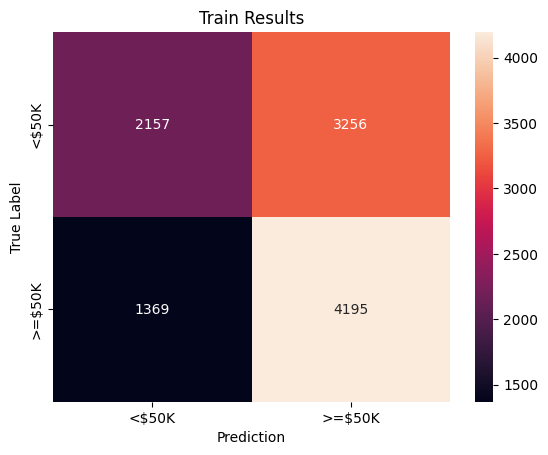

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm_train = confusion_matrix(ys_train.detach().numpy(), out_train.detach().numpy().round())
#cm_train = confusion_matrix(y_train.detach().numpy(), out_train.detach().numpy().round())


#sns.set(rc={'figure.figsize':(8,5)})
cm_train = pd.DataFrame(cm_train,index=['<$50K','>=$50K'],columns =['<$50K','>=$50K'])
sns.heatmap(cm_train,annot=True,fmt='g') #vmin=0,vmax=1,fmt=".1%"
plt.ylabel("True Label")
plt.xlabel("Prediction")
plt.title("Train Results")
plt.show()

### Validation Confusion Matrix

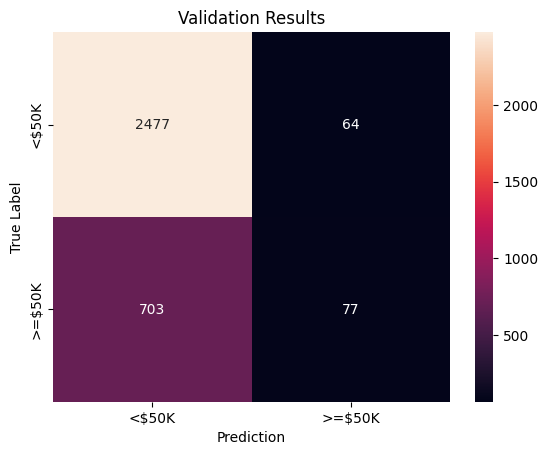

In [ ]:
cm_val = confusion_matrix(y_val.detach().numpy(), out_val.detach().numpy().round())
cm_val = pd.DataFrame(cm_val,index=['<$50K','>=$50K'],columns =['<$50K','>=$50K'])
sns.heatmap(cm_val,annot=True,fmt='g') #vmin=0,vmax=1,fmt=".1%"
plt.ylabel("True Label")
plt.xlabel("Prediction")
plt.title("Validation Results")
plt.show()

### Test Confusion Matrix

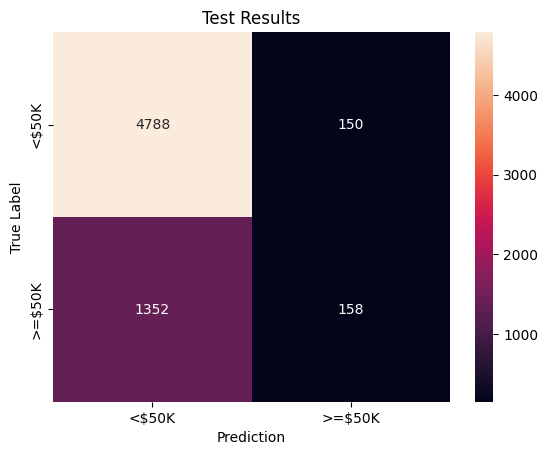

In [ ]:
cm_test = confusion_matrix(y_test.detach().numpy(), outputs_test.detach().numpy().round())
cm_test = pd.DataFrame(cm_test,index=['<$50K','>=$50K'],columns =['<$50K','>=$50K'])
sns.heatmap(cm_test,annot=True,fmt='g') #vmin=0,vmax=1,fmt=".1%"
plt.ylabel("True Label")
plt.xlabel("Prediction")
plt.title("Test Results")
plt.show()

In [ ]:
df.columns

Index(['age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count',
       'priors_count', 'race', 'two_year_recid', 'sex_Female', 'sex_Male',
       'c_charge_degree_F', 'c_charge_degree_M'],
      dtype='object')